# Template for Spectral and temporal modifications Lab


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2019*

**python version : 3.6**

In [16]:
import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
from scipy import signal

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write

## Functions

In [2]:
def load_sound(file):
    return wave.open(file, 'rb')
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

def nextpow2(x):
    assert x>0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2**(p-1) < x <= x_
    return p, x_

def period(x, Fs, Pmin=1/300, Pmax=1/80, seuil=0.7) :
    # [P,voiced] = period(x,Fs,Pmin,Pmax,seuil);
    # If voiced = 1, P is the period signal x expressed in number of samples
    # If voiced = 0, P is equal to 10ms.Fs

    x = x - np.mean(x)
    N = len(x)

    Nmin = np.ceil(Pmin*Fs).astype(int)
    Nmax = 1 + np.floor(Pmax*Fs).astype(int)
    Nmax = np.min([Nmax,N])

    _,Nfft = nextpow2(2*N-1)
    X = np.fft.fft(x, n=Nfft)
    S = X * np.conj(X) / N
    r = np.real(np.fft.ifft(S))

    rmax = np.max(r[Nmin:Nmax])
    I = np.argmax(r[Nmin:Nmax])
    P = I+Nmin
    corr = (rmax/r[0]) * (N/(N-P))
    voiced = corr > seuil
    if not(voiced):
        P = np.round(10e-3*Fs)

    return P,voiced

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [3]:
data_path = os.getcwd()
filename = 'aeiou.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [4]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=59964, comptype='NONE', compname='not compressed')


In [5]:
IPython.display.Audio('aeiou.wav')

In [6]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [7]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

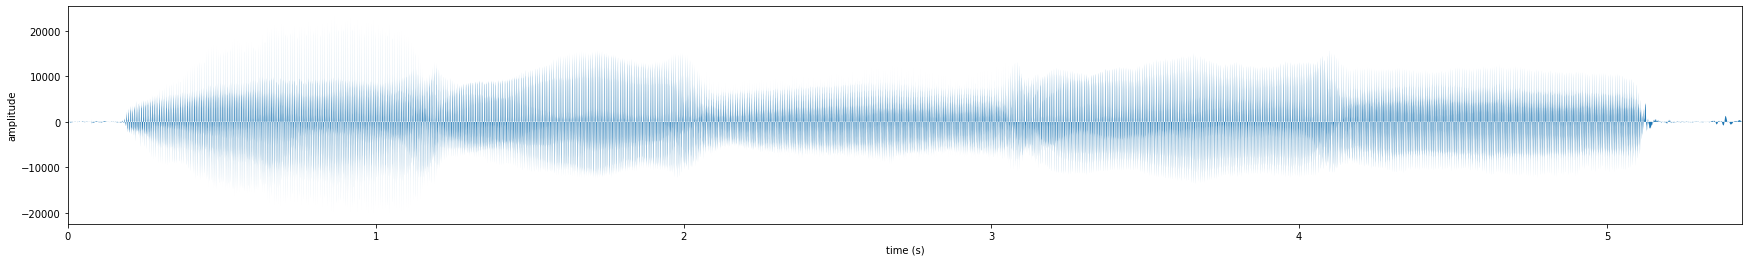

In [8]:
plot_sound(x, times)

In [9]:
write('new_aeiou.wav', Fs, np.array(x, dtype=np.int16)) # to write a new wave file

<h3> <strong> 1. </strong> Extraction of the analysis marks </h3>

In [10]:
def analysisPitchMarks(s,Fs=Fs):
    """ s the signal to be analyzed,
        Fs the sampling frequency,
        
        returns A a 3-row matrix containing at each mark:
        0-row : time marks
        1-row : voiced or not in the neighborhood 
        2-row : time zones 
    """
    #Initialization
    tas = [1]
    voiced = []
    PAs = [0.01 * Fs] #10ms x framerate
    
    #Computation of marks 
    while tas[-1]+np.floor(2.5*PAs[-1]) < len(s) :
        tn_ = tas[-1]
        extr_s = s[int(tn_) : int(tn_+np.floor(2.5*PAs[-1]))]
        [P,voiced_] = period(extr_s,Fs)
        voiced.append(voiced_)
        tas.append(tn_+PAs[-1])
        PAs.append(P)
    
    Nmax = 1 + np.floor(1/80*Fs).astype(int)
    if len(s) - tas[-1] > Nmax: #if the remaining part (even if shorter than the PA we had computed) is long enough 
        tn_ = tas[-1]
        extr_s = s[int(tn_):]
        [P,voiced_] = period(extr_s,Fs)
        voiced.append(voiced_)
        PAs.append(len(s) - tas[-1])
        
    #Creation and filling of matrix A
    n = len(voiced) #number of landmarks (the last one won't count)
    A = np.zeros((3,n))
    for i in range(n):
        A[0][:] = tas[:n]
        A[1][:] = voiced[:n]
        A[2][:] = PAs[:n]
    return A

In [11]:
print(np.shape(analysisPitchMarks(x,Fs)))
print(np.mean(analysisPitchMarks(x,Fs)[2]))

(3, 708)
84.49046610169492


<h3> <strong> 2. </strong> Synthesis </h3>

In [53]:
A = analysisPitchMarks(x,Fs)
B_default = np.zeros((np.shape(A)[0]-1,np.shape(A)[1]))
B_default[0,:] = A[0,:]
B_default[1,:] = np.arange(len(B_default[1,:])) #B_default constructed as proposed in the subject

In [710]:
def Synthesis(s,Fs,A,B=B_default):
    """
        returns the synthesized y signal
    """
    A = analysisPitchMarks(s,Fs)
    lenA = np.shape(A)[1]
    k_end = 0
    while int((B[1,k_end]))<np.shape(A)[1]-1:
        k_end+=1
    print("k_end is equal to "+str(k_end))
    len_y = int(B[0,k_end] + A[2,int((B[1,k_end]))])
    print("Length of synthesized signal : "+str(len_y))
    y = np.zeros(len_y)
    print("Longueur de B "+str(len(B[0])))
    for k in range(k_end):
        nk = int(B[1,k])
        
        if nk>=lenA:
            return y #acts just like a break, if we go too far we just give back what we already overlapped/added
        
        #so now if we are here, that means we have nk<lenA
        tank = int(A[0,nk])
        pank = int(A[2,nk])
        left_bound  = max(0,tank-pank)
        right_bound = min(tank+pank+1,len(s))
        x_extract = s[left_bound:right_bound] #the middle value is the +1 of the len 2Pa_(n_k) + 1. The +1 in tank+pank+1 is for the removed end value of slicing. 
        x_windowed = np.multiply(x_extract,signal.windows.hann(right_bound-left_bound)) #length of x_extract
        tsk = int(B[0,k])
        bound_left, bound_right = max(0,tsk-pank), tsk+pank+1

        #well-defined bounds to make sure we have no "effets de bord" which were painfully difficult to deal with
        if bound_right<len_y:
            if tsk-pank<0 and len(x_windowed)>bound_right-bound_left+1:
                x_windowed = x_windowed[len(x_windowed)-bound_right-bound_left:]
            y[bound_left:bound_right] += x_windowed #slicing on y to make sure we get rid of "effets de bord" and add only where it's needed
        else:
            y[bound_left:] += x_windowed[:len_y-bound_left]
    return y

Dealing with side effects (effets de bord) was really really hard. The reasons for that is that taking a sample of the signal "centered" somewhere means our bounds can land outside of the signal edges. Which means we sometimes don't take enough samples, or too much, when we're on the edges of the signal. (low k or end k) 
As you can see, I tried coding properly with min and max functions, but there are simply to many cases to deal with ! And that's why there are a few exceptions at the end of the function. 

In [711]:
synth_ = Synthesis(x,Fs,A,B=B_default)

k_end is equal to 707
Length of synthesized signal : 59820
Longueur de B 708


In [712]:
times_ = np.arange(len(synth_))*timestep

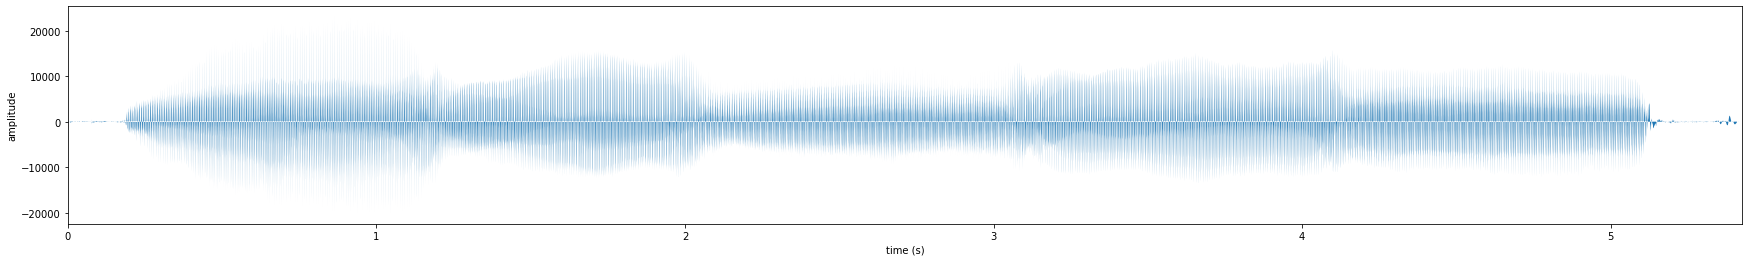

In [713]:
plot_sound(synth_, times_)

In [714]:
write('synth1_aeiou.wav', Fs, np.array(synth_, dtype=np.int16)) # to write a new wave file

In [715]:
filename = 'synth1_aeiou.wav'
sound = os.path.join(data_path, filename)
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=59820, comptype='NONE', compname='not compressed')


In [716]:
IPython.display.Audio('synth1_aeiou.wav')

We can clearly hear the original sound, there's almost no difference between the original and the synthesized one. We can be happy with our result ! The waveform looks exactly the same as previously and the length of the signal is also the same. 

<h3> <strong> 3.1 </strong> Time Scale changing </h3>

In [717]:
def ChangeTimeScale(alpha,A,Fs):
    """
        returns the B matrix for modified TEMPORAL (length) scale synthesizing of a signal
    """
    
    tsk = [0]  #t_0 = 1, initialization of tsk value
    ts_k = 0
    nk = [1] #n_1 = 1, initialization of nk value
    n_k = 1
    
    #Note that for "effets de bords" once again we are forced to use a while loop.
    #I tried initializing once and for all the B matrix but it's simply impossible.
    #It's never of the right size, and it doesn't contain the right information. 
    
    while int(np.floor(n_k))<np.shape(A)[1]-1:
        n_k += 1/alpha
        nk.append(int(n_k))
        ts_k += A[2,int(np.floor(n_k))]
        tsk.append(ts_k)
    nk = np.array(nk).reshape((1,len(nk)))
    tsk = np.array(tsk).reshape((1,len(tsk)))
    B = np.concatenate((tsk,nk),axis=0)
    return B

So the goal of the function is to modify the speed of the speech without changing the pitch. Which means we expect less samples than before if we want to accelerate the signal, or more samples when we try to slow it down. For this reason, the length of the resulting signal array can't be easily determined beforehand. Which means, after of a struggle to implement it with a first and final B initialization, I went for a while loop that kept calculating nk's and tsk's until we're done with the computations.</br>
I noticed there was a problem when I tried using the function to extend the duration of the signal, because it simply cut the speech. We heard distincly a longer A, a longer E, a longer I, a little bit of the O and then it cut off at 5 seconds. We simply didn't make the remaining samples, even though until then we actually made the letters longer. 
Now, it works !

In [741]:
alpha = 0.5
A = analysisPitchMarks(x,Fs)
synth_ = Synthesis(x,Fs,A,B=ChangeTimeScale(alpha,A,Fs))

k_end is equal to 353
Length of synthesized signal : 29857
Longueur de B 354


Here, we can see clearly that the length of the synthesized signal is nearly twice as low as the original one, which is exactly what we wanted as alpha=0.5 is equivalent to reducing the time by a factor, which is again equivalent to speeding x2 the speech. 

In [742]:
times_ = np.arange(len(synth_))*timestep

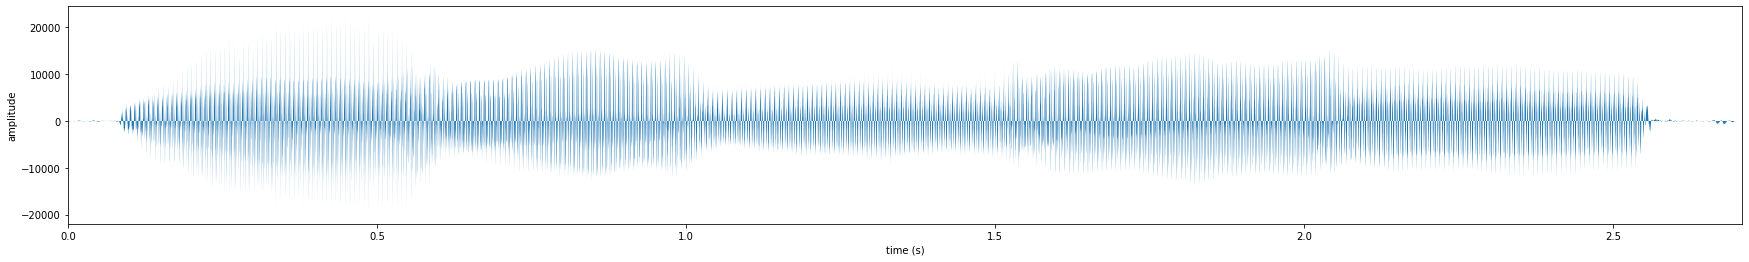

In [743]:
plot_sound(synth_, times_)

In [744]:
write('synth2_aeiou.wav', Fs, np.array(synth_, dtype=np.int16)) # to write a new wave file

In [745]:
filename = 'synth2_aeiou.wav'
sound = os.path.join(data_path, filename)
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=29857, comptype='NONE', compname='not compressed')


In [746]:
IPython.display.Audio('synth2_aeiou.wav')

It's very easy to notice that the signal has been quickened, the speech goes faster but the pitch hasn't been changed ! The code works well.

<h3> <strong> 3.2 </strong> Pitch Scale changing </h3>

In [725]:
def ChangePitchScale(beta,A,Fs):
    """
        returns the B matrix for modified SPECTRAL (pitch) scale synthesizing of a signal
    """
    tsk = [0] #This is ts_0 = 0, it will get lost in matrix B that will start at k=1
    ts_k = 0
    nk = [1] #n_1 = 1, initialization of nk value
    n_k = 1
    while int(np.floor(n_k))<np.shape(A)[1]-1:
        if A[1,int(np.floor(n_k))]: #if voiced:
            scale_k = 1/beta
        else:
            scale_k = 1      
        n_k += scale_k
        nk.append(int(n_k))
        ts_k += scale_k*A[2,int(np.floor(n_k))]
        tsk.append(ts_k)
    nk = np.array(nk).reshape((1,len(nk)))
    tsk = np.array(tsk).reshape((1,len(tsk)))
    B = np.concatenate((tsk,nk),axis=0)
    return B

A function that once again I tried implementing with a definite initialization but I ended up going for a while loop because it was simply impossible to make it work. 

In [726]:
beta = 2
A = analysisPitchMarks(x,Fs)
synth_ = Synthesis(x,Fs,A,B=ChangePitchScale(beta,A,Fs))

k_end is equal to 1366
Length of synthesized signal : 59826
Longueur de B 1367


In [727]:
times_ = np.arange(len(synth_))*timestep

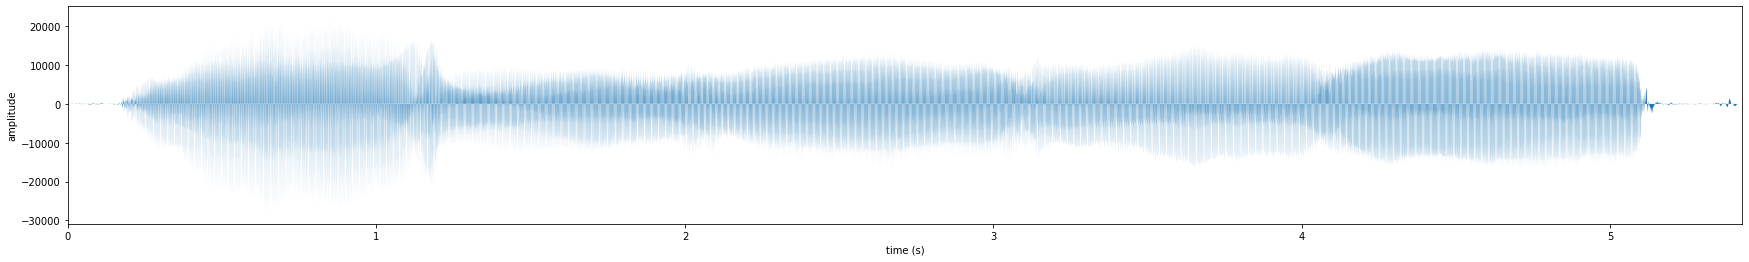

In [728]:
plot_sound(synth_, times_)

In [729]:
write('synth2_aeiou.wav', Fs, np.array(synth_, dtype=np.int16)) # to write a new wave file

In [730]:
filename = 'synth2_aeiou.wav'
sound = os.path.join(data_path, filename)
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=59826, comptype='NONE', compname='not compressed')


In [732]:
IPython.display.Audio('synth2_aeiou.wav')

The function works well, we can hear that the pitch has been changed (raised exactly by an octave here, beta = 2 so all freqs were multiplied by 2) but not the speed ! And we have the right amount of samples so we're satisfied. 

In [733]:
def ChangeBothScales(alpha,beta,A,Fs):
    """
        returns the B matrix for modified SPECTRAL (pitch) scale synthesizing of a signal
    """
    tsk = [0] #This is ts_0 = 0, it will get lost in matrix B that will start at k=1
    ts_k = 0
    nk = [1] #n_1 = 1, initialization of nk value
    n_k = 1
    while int(np.floor(n_k))<np.shape(A)[1]-1:
        scale_k = 1
        if A[1,int(np.floor(n_k))]: #if voiced:
            scale_k *= 1/beta
        n_k += scale_k/alpha
        nk.append(int(n_k))
        ts_k += scale_k*A[2,int(np.floor(n_k))]
        tsk.append(ts_k)
    nk = np.array(nk).reshape((1,len(nk)))
    tsk = np.array(tsk).reshape((1,len(tsk)))
    B = np.concatenate((tsk,nk),axis=0)
    return B

In [734]:
alpha = 0.5
beta = 0.5
A = analysisPitchMarks(x,Fs)
synth_ = Synthesis(x,Fs,A,B=ChangeBothScales(alpha,beta,A,Fs))

k_end is equal to 187
Length of synthesized signal : 29955
Longueur de B 188


In [735]:
times_ = np.arange(len(synth_))*timestep

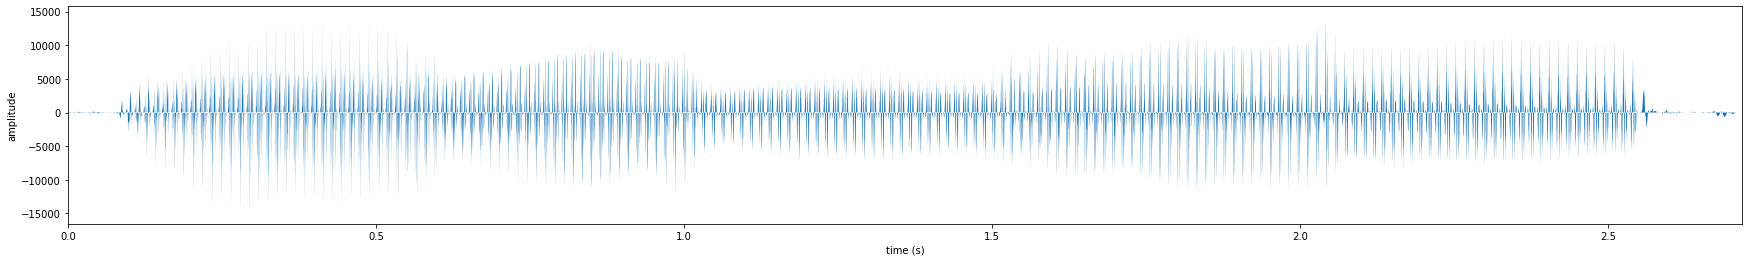

In [736]:
plot_sound(synth_, times_)

In [737]:
write('synth2_aeiou.wav', Fs, np.array(synth_, dtype=np.int16)) # to write a new wave file

In [738]:
filename = 'synth2_aeiou.wav'
sound = os.path.join(data_path, filename)
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=29955, comptype='NONE', compname='not compressed')


In [739]:
IPython.display.Audio('synth2_aeiou.wav')

For the last function that combined both previous ones and synthesize, I just meshed and merged both codes, carefully implementing the scale part (not messing up the beta and alpha part was important) and we have a function that does both pitch modification and speed modification. This last function really looks a lot like the previous ones, the only difference between this and the TimeScale one is the voiced part and the beta (because we only change the pitch of voiced part), whereas the only difference with the PitchScale is the alpha that extends or reduces the length of the signal. 
</br> 
The result is very satisfying indeed, we have a lower-pitch signal that's still faster than the original. 

<strong>*B. Moalic & G. Capitan*</strong>